***
# ***Notebook Introduction***
***
Approximate Total Runtime: 15 minutes

***
# ***Part 0 - Preparing the environment***
***
Before we start, we import the necessary libraries for the analysis and create a color palette for the plots.


In [106]:
# Importing necessary libraries
import pandas as pd                                   # For data manipulation and analysis
import numpy as np                                    # For numerical operations
import matplotlib.pyplot as plt                       # For plotting graphs
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets

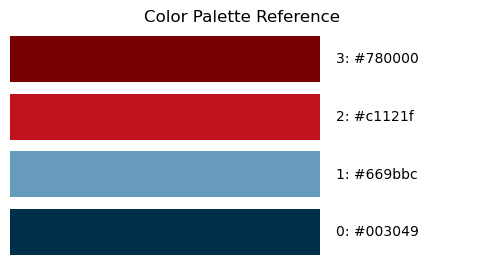

In [65]:
# Color palette for the plots
colors = ['#003049','#669bbc','#c1121f', '#780000']

# Plotting the color palette for easy reference
plt.figure(figsize=(6, 3))
for i, color in enumerate(colors):
    _ = plt.barh(y=i, width=1, color=color)
    _ =plt.text(x=1.05, y=i, s=f"{i}: {color}", va='center')

# Adjust plot limits and turn off axes
plt.ylim(-0.5, len(colors) - 0.5)
plt.xlim(0, 1.5)
plt.axis("off")
_ = plt.title("Color Palette Reference")

***
# ***Part 1 - Data Preprocessing***
***

In [66]:
# Loading the datasets
name = 'SCF_' 
years = ['1989', '1992', '1995', '1998', '2001', '2004', '2007', '2010', '2013', '2016', '2019', '2022']

# Reading the CSV files into DataFrames, creating a year column, and unpacking them into individual variables
df_1989, df_1992, df_1995, df_1998, df_2001, df_2004, df_2007, df_2010, df_2013, df_2016, df_2019, df_2022 = [pd.read_csv(f'{name}{year}.csv').assign(year = int(year)) 
                                                                                                              for year in years]

In [67]:
# Merge the DataFrames into a single DataFrame
df = pd.concat([df_1989, df_1992, df_1995, df_1998, df_2001, df_2004, df_2007, df_2010, df_2013, df_2016, df_2019, df_2022], ignore_index=True)

In [68]:
# Display all columns in the DataFrame
print(df.columns)

Index(['weight', 'age', 'female', 'married', 'educ', 'kids', 'race', 'lfpart',
       'empl', 'income', 'wageinc', 'ssretinc', 'intdivinc', 'busfarminc',
       'capgainsinc', 'othinc', 'owner', 'rent', 'hpayday', 'bankrupt5y',
       'latepay60d', 'creditapplied', 'creditdenied', 'takefinrisk',
       'finknowledge', 'finlit', 'equity', 'finassets', 'liqassets', 'houses',
       'business', 'vehicles', 'assets', 'networth', 'stocks', 'stkmutfnd',
       'othresre', 'netnresre', 'othnfin', 'mortages', 'heloc', 'othloc',
       'instloanveh', 'instloaneduc', 'instloanoth', 'ccbalance', 'debt',
       'totloanpay', 'year'],
      dtype='object')


In [69]:
# Compute the weighted 0.1 and 99th percentiles of networth by using the weight column
p001, p99 = np.percentile(df['networth'], [0.1, 99], weights=df['weight'], method='inverted_cdf')

In [70]:
# Filter the DataFrame based on the computed percentiles, keeping only the rows where:
#           - 'networth' is between the 0.1th and 99th percentiles
#           - 'age' is between 20 and 80
#           - 'gross_assets' and 'wage_income' are non-negative
df = df[
    (df["networth"] >= p001) &
    (df["networth"] <= p99) &
    (df["age"] >= 20) &
    (df["age"] <= 80) &
    (df["assets"] >= 0) &
    (df["wageinc"] >= 0)
]


In [71]:
# Create an empty list to store sampled data for each year
samples = []

# Loop through each survey year
for year in years:
    year = int(year)
    df_year = df[df['year'] == year]

    # Draw 10 000 observations with replacement using the sampling weights
    sampled = df_year.sample(n = 10_000, replace = True, weights = df_year['weight'], random_state = 1234)
    samples.append(sampled)

# Concatenate all yearly samples into one DataFrame
df_sample = pd.concat(samples, ignore_index=True)


In [72]:
# Variables to rank
variables_to_rank = ['assets', 'networth', 'income', 'wageinc', 'liqassets', 'debt', 'houses', 'finassets']

# Efficiently compute all ranks using groupby and transform
for var in variables_to_rank:
    df_sample[f"{var}_rank"] = (
        df_sample
        .groupby("year")[var]
        .transform(lambda x: (x.rank(method = 'first') - 1) / (len(x) - 1)) # - 1 to start ranks at 0 and divide by (len(x) - 1) to scale to [0, 1]
    )

In [73]:
# Check number of observations to enure we have 120 000 observations
print(f'Number of observations in df_sample: {len(df_sample)}')

Number of observations in df_sample: 120000


In [74]:
# Creating additional variables 

# 1. Creating a college variable that takes the value 1 if the individual has a bachelors degree or higher
df_sample["college"] = (df_sample["educ"] >= 4).astype(int)

# 2. Creating a white variable that takes the value 1 if the individual is white non-Hispanic
df_sample["white"] = (df_sample["race"] == 1).astype(int)

# 3. Creating a part variable that takes the value 1 if the households > $100 in stocks or mutual funds
df_sample["part"] = ((df_sample["stocks"] > 100) | (df_sample["stkmutfnd"] > 100)).astype(int)

# 4. Creating a part_any variable that takes the value 1 if the households > $100 in equity
df_sample["part_any"] = (df_sample["equity"] > 100).astype(int)


***
# ***Part 2 - Participation: Exploratory Data Analysis***
***

In [75]:
# Compute the correlation matrix for numeric columns only
corr_matrix = df_sample.corr(numeric_only=True)

# Variables to exclude from the correlation analysis
exclude = ['part', 'part_any', 'stocks', 'stkmutfnd', 'equity']

# Compute correlation with 'part_any' and 'part' 
corr_part_any = corr_matrix.loc["part_any"].drop(exclude, errors='ignore').abs().sort_values(ascending=False)
corr_part = corr_matrix.loc["part"].drop(exclude, errors='ignore').abs().sort_values(ascending=False)

In [76]:
# Display the top 20 variables most correlated with 'part'
print("Top 20 variables most correlated with 'part_any':")
print(corr_part_any.head(20))

Top 20 variables most correlated with 'part_any':
finassets_rank    0.659454
assets_rank       0.533490
income_rank       0.526957
networth_rank     0.485374
liqassets_rank    0.463201
wageinc_rank      0.415664
houses_rank       0.390655
educ              0.382419
takefinrisk       0.359051
assets            0.328819
college           0.327503
debt_rank         0.326067
wageinc           0.321285
houses            0.314620
owner             0.308877
networth          0.303447
finassets         0.303059
totloanpay        0.294798
finlit            0.289829
vehicles          0.286003
Name: part_any, dtype: float64


In [77]:
# Display the top 20 variables most correlated with 'part'
print("\nTop 20 variables most correlated with 'part':")
print(corr_part.head(20))


Top 20 variables most correlated with 'part':
finassets_rank    0.490931
assets_rank       0.433887
networth_rank     0.423392
liqassets_rank    0.388354
assets            0.373668
finassets         0.368739
networth          0.366403
income_rank       0.365621
houses_rank       0.320457
houses            0.303551
educ              0.299436
college           0.292801
takefinrisk       0.267937
wageinc           0.260873
finlit            0.249751
income            0.242324
intdivinc         0.224183
wageinc_rank      0.224096
owner             0.210333
vehicles          0.209871
Name: part, dtype: float64


In [101]:
def plot_participation(
    df, 
    group_col, 
    part_cols=('part_any', 'part'), 
    bins=None, 
    bin_labels=None, 
    title=None, 
    rotate_xticks=False,
    colors=colors,
    ax=None  # New optional parameter for plotting on an existing axis
):
    """
    Plots the average of each variable in 'part_cols' by groups of 'group_col'.
    If 'bins' is provided, we first cut 'group_col' into discrete bins.
    
    Parameters:
    -----------
    df         : pd.DataFrame
                 The data frame containing the data.
    group_col  : str
                 Column name in df by which to group (e.g., 'networth', 'age', or 'income').
    part_cols  : tuple of str
                 The participation columns for which to compute means.
    bins       : list or np.ndarray, optional
                 If not None, defines numeric bin edges for pd.cut() on 'group_col'.
    bin_labels : list, optional
                 Labels for the bins. If None, pd.cut() will generate default labels.
    title      : str, optional
                 Plot title. If None, a default title is generated.
    rotate_xticks : bool, optional
                 Whether to rotate x-axis tick labels.
    colors     : list, optional
                 List of colors for the bars. Defaults to a predefined color palette.
    ax         : matplotlib.axes.Axes, optional
                 If provided, the plot is drawn on this axis; otherwise, a new figure is created.
    
    Returns:
    --------
    ax : matplotlib.axes.Axes
         The axis containing the plot.
    """
    data = df.copy()

    # If bins are provided, create a binned version of group_col
    if bins is not None:
        data[group_col + '_binned'] = pd.cut(
            data[group_col],
            bins=bins,
            labels=bin_labels,
            include_lowest=True
        )
        group_by_col = group_col + '_binned'
    else:
        group_by_col = group_col

    # Group by the specified column (or binned column) and compute the mean of participation
    means = data.groupby(group_by_col, observed = True)[list(part_cols)].mean()

    # Create a new figure and axis if one isn't provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    # Plot as a bar chart on the given axis
    means.plot(kind='bar', ax=ax, color=colors)
    if title is None:
        title = f"Average {part_cols} by {group_col}"
    ax.set_title(title)
    ax.set_ylabel("Mean participation")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Optionally rotate x-axis tick labels
    if rotate_xticks:
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.tick_params(axis='x', rotation=0)

    ax.legend(part_cols)
    plt.tight_layout()
    
    return ax


<Axes: title={'center': 'Participation by Willingness to Take Financial Risk'}, xlabel='takefinrisk_binned', ylabel='Mean participation'>

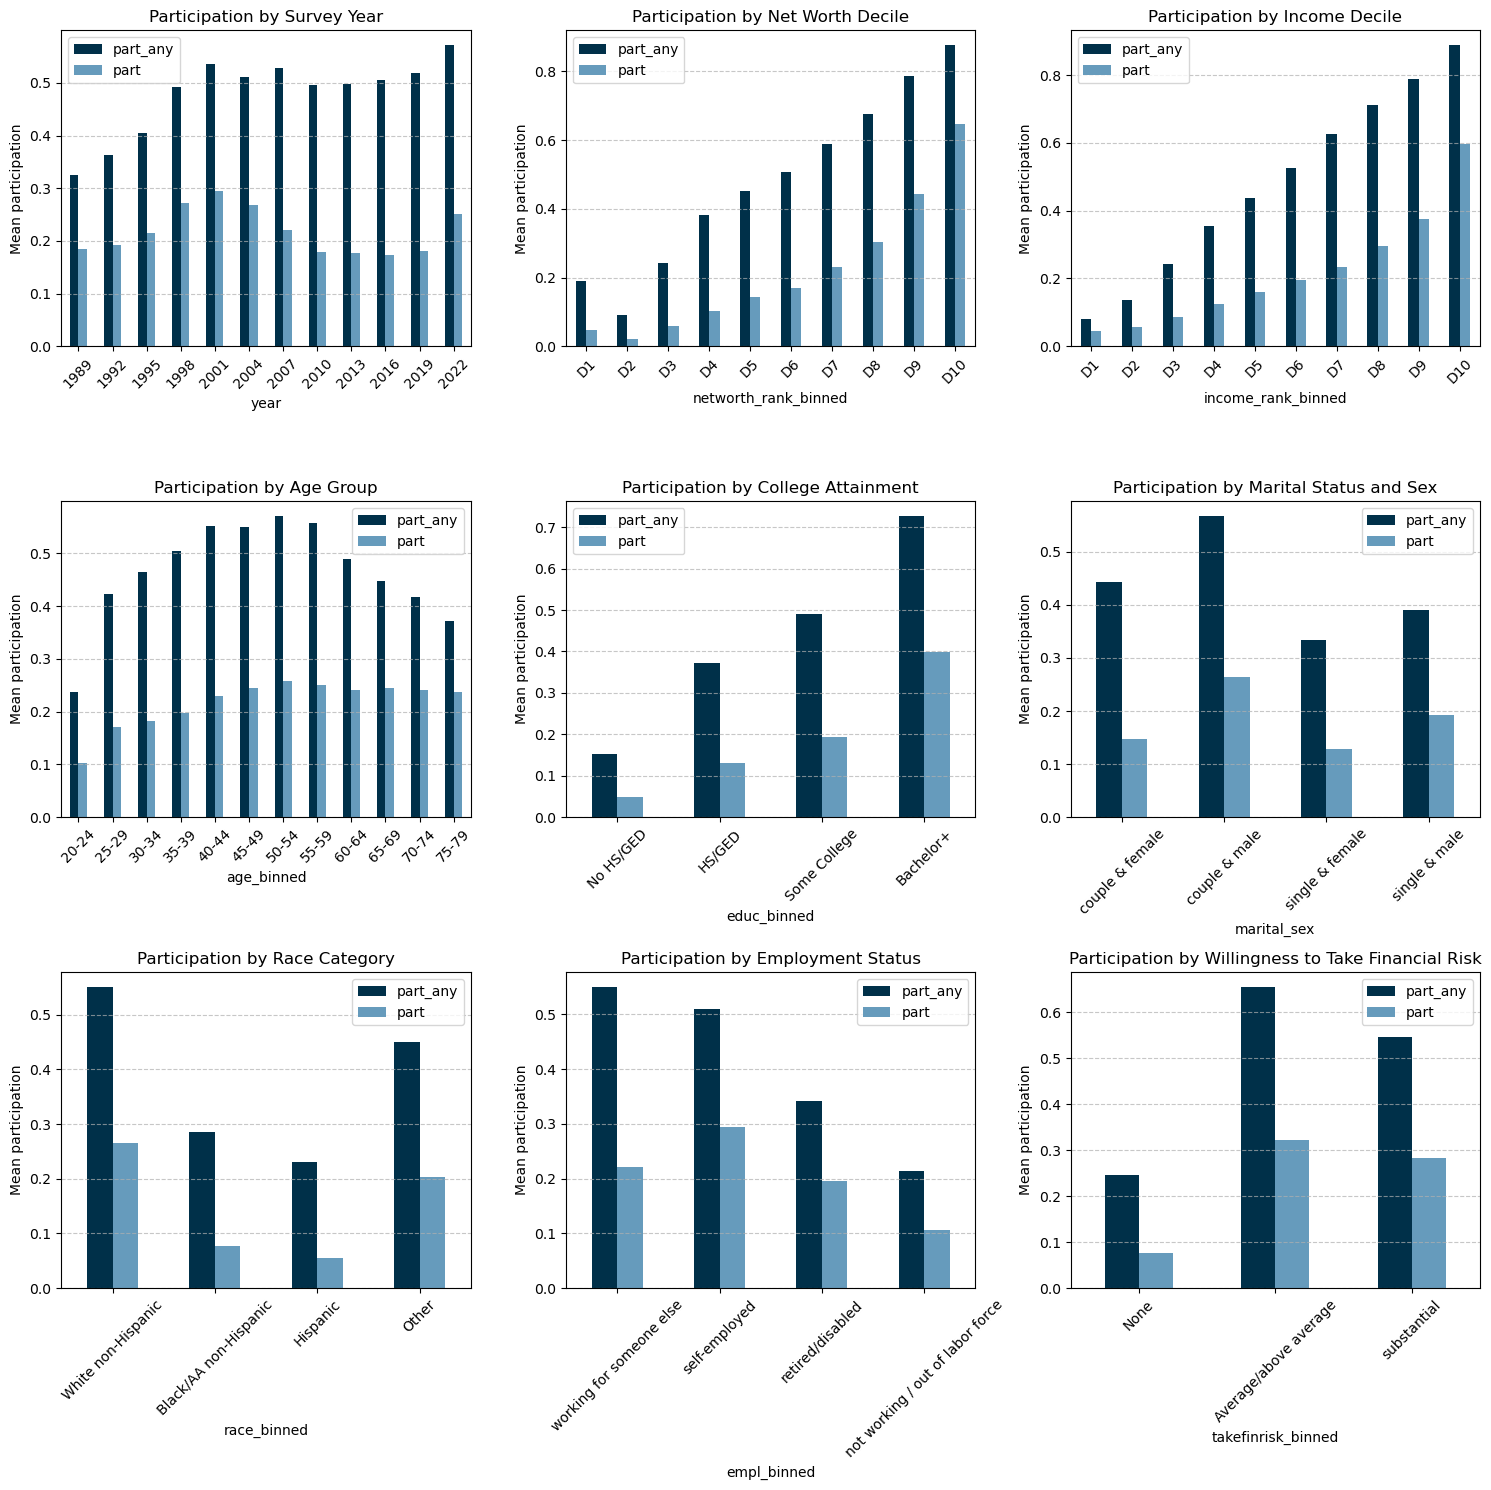

In [ ]:
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.ravel()  # Flatten the array for easier indexing

# 1. Plot by Survey Year
plot_participation(
    df=df_sample,
    group_col='year',
    title="Participation by Survey Year",
    rotate_xticks=True,
    ax=axs[0]
)

# 2. Plot by Net Worth Deciles
networth_deciles = np.percentile(df_sample['networth_rank'], np.arange(0, 101, 10))
decile_labels = [f"D{i}" for i in range(1, 11)]
plot_participation(
    df=df_sample,
    group_col='networth_rank', 
    bins=networth_deciles, 
    bin_labels=decile_labels,
    title="Participation by Net Worth Decile",
    rotate_xticks=True,
    ax=axs[1]
)

# 3. Plot by Household Income Deciles
income_deciles = np.percentile(df_sample['income_rank'], np.arange(0, 101, 10))
decile_labels = [f"D{i}" for i in range(1, 11)]
plot_participation(
    df=df_sample,
    group_col='income_rank', 
    bins=income_deciles, 
    bin_labels=decile_labels,
    title="Participation by Income Decile",
    rotate_xticks=True,
    ax=axs[2]
)

# 4. Plot by Age Groups (5-year intervals)
age_bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins) - 1)]
plot_participation(
    df=df_sample,
    group_col='age', 
    bins=age_bins, 
    bin_labels=age_labels,
    title="Participation by Age Group",
    rotate_xticks=True,
    ax=axs[3]
)

# 5. Plot by Education Level
education_bins = [0.5, 1.5, 2.5, 3.5, 4.5]
education_labels = ['No HS/GED', 'HS/GED', 'Some College', 'Bachelor+']
plot_participation(
    df=df_sample,
    group_col='educ',
    bins=education_bins,
    bin_labels=education_labels,
    title="Participation by College Attainment",
    rotate_xticks=True,
    ax=axs[4]
)

# 6. Plot by Marital Status and Sex
df_sample['marital_sex'] = np.select(
    condlist=[
        (df_sample['married'] == 0) & (df_sample['female'] == 0),
        (df_sample['married'] == 0) & (df_sample['female'] == 1),
        (df_sample['married'] == 1) & (df_sample['female'] == 0),
        (df_sample['married'] == 1) & (df_sample['female'] == 1)
    ],
    choicelist=[
        'single & male',
        'single & female',
        'couple & male',
        'couple & female'
    ],
    default='other'
)
plot_participation(
    df=df_sample,
    group_col='marital_sex',
    title="Participation by Marital Status and Sex",
    rotate_xticks=True,
    ax=axs[5]
)

# 7. Plot by Race Categories
race_bins = [0.5, 1.5, 2.5, 3.5, 4.5]
race_labels = ['White non-Hispanic', 'Black/AA non-Hispanic', 'Hispanic', 'Other']
plot_participation(
    df=df_sample,
    bins=race_bins,
    bin_labels=race_labels,
    group_col='race',
    title="Participation by Race Category",
    rotate_xticks=True,
    ax=axs[6]
)

# 8. Plot by Employment Status
empl_bins = [0.5, 1.5, 2.5, 3.5, 4.5]
empl_labels = ['working for someone else', 'self-employed', 'retired/disabled', 'not working / out of labor force']
plot_participation(
    df=df_sample,
    bins=empl_bins,
    bin_labels=empl_labels,
    group_col='empl', 
    title="Participation by Employment Status",
    rotate_xticks=True,
    ax=axs[7]
)

# 9. Plot by Willingness to Take Financial Risk
risk_bins = [-0.5, 0.5, 1.5, 2.5]
risk_labels = ['None', 'Average/above average', 'substantial']
plot_participation(
    df=df_sample,
    bins=risk_bins,
    bin_labels=risk_labels,
    group_col='takefinrisk',
    title="Participation by Willingness to Take Financial Risk",
    rotate_xticks=True,
    ax=axs[8]
)

plt.tight_layout()
plt.show()

***
# ***Part 3 - Predicting Participation***
***

In [ ]:


# Create the stratum variable (1 for each unique year × part combination)
df_sample["stratum"] = df_sample["year"] * 2 + df_sample["part"]

# Print the number of strata which should be 24
print("Number of unique strata:", df_sample["stratum"].nunique())

# Tabulate stratum sizes
print("\nObservations per stratum:")
print(df_sample["stratum"].value_counts().sort_index())

# Train-test split using stratification
train_df, test_df = train_test_split(
    df_sample,
    test_size=0.2,
    stratify=df_sample["stratum"],
    random_state=1234  # for reproducibility
)

# Confirm the split size
print(f"\nTrain size: {len(train_df)}, Test size: {len(test_df)}")
